In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.metrics import pairwise_distances

# --- Load and subsample data ---
mnist = fetch_openml("mnist_784", as_frame=False)
X, y = mnist.data, mnist.target.astype(int)
random_state = 42

size = 2500  # smaller for CPU compute
idx = np.random.choice(len(X), size=size, replace=False)
X_sub, y_sub = X[idx], y[idx]

# --- Scale ---
X_scaled = StandardScaler().fit_transform(X_sub)

In [ ]:
# ==========================
# Metric vs Classical MDS
# ==========================

# --- Hyperparameter grid ---
r_list = [2, 5, 10, 20, 40, 60]
n_init_list = [4]
max_iter = 400

def run_mds(metric=True):
    results = []
    for r in r_list:
        for n_init in n_init_list:
            try:
                mds = MDS(
                    n_components=r,
                    n_init=n_init,
                    max_iter=max_iter,
                    random_state=random_state,
                    dissimilarity='euclidean',
                    normalized_stress='auto',
                    metric=metric
                )
                Z = mds.fit_transform(X_scaled)

                # --- Supervised evaluation ---
                Z_tr, Z_ts, y_tr, y_ts = train_test_split(
                    Z, y_sub, test_size=0.2, random_state=random_state, stratify=y_sub
                )

                clf = LogisticRegression(max_iter=1000, n_jobs=-1)
                clf.fit(Z_tr, y_tr)
                acc = accuracy_score(y_ts, clf.predict(Z_ts))
                results.append((r, n_init, acc))
                print(f"{'Metric' if metric else 'Classical'} MDS -> r={r:>2}, n_init={n_init}, acc={acc:.4f}")

            except Exception as e:
                print(f"{'Metric' if metric else 'Classical'} MDS -> r={r:>2}, n_init={n_init} skipped ({type(e).__name__})")
    return results


# --- Run both versions ---
results_metric = run_mds(metric=True)
results_classical = run_mds(metric=False)

# --- Convert to matrices ---
r_vals = sorted(set(r_list))
n_vals = sorted(set(n_init_list))

acc_metric = np.zeros((len(r_vals), len(n_vals)))
acc_classical = np.zeros((len(r_vals), len(n_vals)))

for r, n, acc in results_metric:
    acc_metric[r_vals.index(r), n_vals.index(n)] = acc

for r, n, acc in results_classical:
    acc_classical[r_vals.index(r), n_vals.index(n)] = acc

# --- Find best ---
def best_params(acc_matrix):
    idx = np.unravel_index(np.argmax(acc_matrix), acc_matrix.shape)
    return idx, acc_matrix[idx]

best_idx_metric, best_acc_metric = best_params(acc_metric)
best_idx_classical, best_acc_classical = best_params(acc_classical)

best_r_metric = r_vals[best_idx_metric[0]]
best_n_metric = n_vals[best_idx_metric[1]]
best_r_classical = r_vals[best_idx_classical[0]]
best_n_classical = n_vals[best_idx_classical[1]]

print(f"\nBest Metric MDS: r={best_r_metric}, n_init={best_n_metric}, Accuracy={best_acc_metric:.4f}")
print(f"Best Classical MDS: r={best_r_classical}, n_init={best_n_classical}, Accuracy={best_acc_classical:.4f}")


Metric MDS -> r= 2, n_init=4, acc=0.3780
Metric MDS -> r= 5, n_init=4, acc=0.6300
Metric MDS -> r=10, n_init=4, acc=0.7320
Metric MDS -> r=20, n_init=4, acc=0.7780
Metric MDS -> r=40, n_init=4, acc=0.8140
Metric MDS -> r=60, n_init=4, acc=0.7920
Classical MDS -> r= 2, n_init=4, acc=0.1220
Classical MDS -> r= 5, n_init=4, acc=0.0980
Classical MDS -> r=10, n_init=4, acc=0.1100
Classical MDS -> r=20, n_init=4, acc=0.0880
Classical MDS -> r=40, n_init=4, acc=0.1260
Classical MDS -> r=60, n_init=4, acc=0.1160

Best Metric MDS: r=40, n_init=4, Accuracy=0.8140
Best Classical MDS: r=40, n_init=4, Accuracy=0.1260


Issues with Classical MDS - will rerun. keeping last code block because it takes 10 minutes to run on CPU - Metric MDS is very very slow.

In [7]:
# ==========================
# Classical MDS (Eigen Decomposition)
# ==========================

# --- Define Classical MDS ---
def classical_mds(D, k):
    """
    Perform classical (metric) MDS using eigen-decomposition.
    D: (n x n) distance matrix.
    Returns an (n x k) configuration.
    """
    n = D.shape[0]
    D2 = D ** 2
    J = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * J.dot(D2).dot(J)
    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    L = np.diag(np.sqrt(np.maximum(eigvals[:k], 0)))
    V = eigvecs[:, :k]
    X = V.dot(L)
    return X

size = 3000  # smaller subset for compute efficiency
idx = np.random.choice(len(X), size=size, replace=False)
X_sub, y_sub = X[idx], y[idx]

# --- Scale features (mean center only for MDS) ---
X_scaled = StandardScaler(with_std=False).fit_transform(X_sub)

# --- Compute distance matrix once ---
print("Computing distance matrix...")
D = pairwise_distances(X_scaled, metric='euclidean')
print("Done.")

# --- Hyperparameter grid ---
r_list = [2, 5, 10, 20, 40, 60]
_results = []

for r in r_list:
    try:
        print(f"Running Classical MDS for r={r}...")
        Z = classical_mds(D, r)
        Z_tr, Z_ts, y_tr, y_ts = train_test_split(Z, y_sub, test_size=0.2,
                                                  random_state=random_state, stratify=y_sub)

        clf = LogisticRegression(max_iter=1000, n_jobs=-1)
        clf.fit(Z_tr, y_tr)
        acc = accuracy_score(y_ts, clf.predict(Z_ts))
        _results.append((r, acc))
        print(f"r={r:>2}, Accuracy={acc:.4f}")
    except Exception as e:
        print(f"r={r:>2} -> skipped ({type(e).__name__})")

# --- Results summary ---
r_vals, acc_vals = zip(*_results)
best_idx = np.argmax(acc_vals)
best_r, best_acc = r_vals[best_idx], acc_vals[best_idx]
print(f"\nBest Classical MDS: r={best_r}, Accuracy={best_acc:.4f}")

Computing distance matrix...
Done.
Running Classical MDS for r=2...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


r= 2, Accuracy=0.4417
Running Classical MDS for r=5...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


r= 5, Accuracy=0.6733
Running Classical MDS for r=10...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


r=10, Accuracy=0.7967
Running Classical MDS for r=20...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


r=20, Accuracy=0.8500
Running Classical MDS for r=40...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


r=40, Accuracy=0.8750
Running Classical MDS for r=60...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


r=60, Accuracy=0.8633

Best Classical MDS: r=40, Accuracy=0.8750


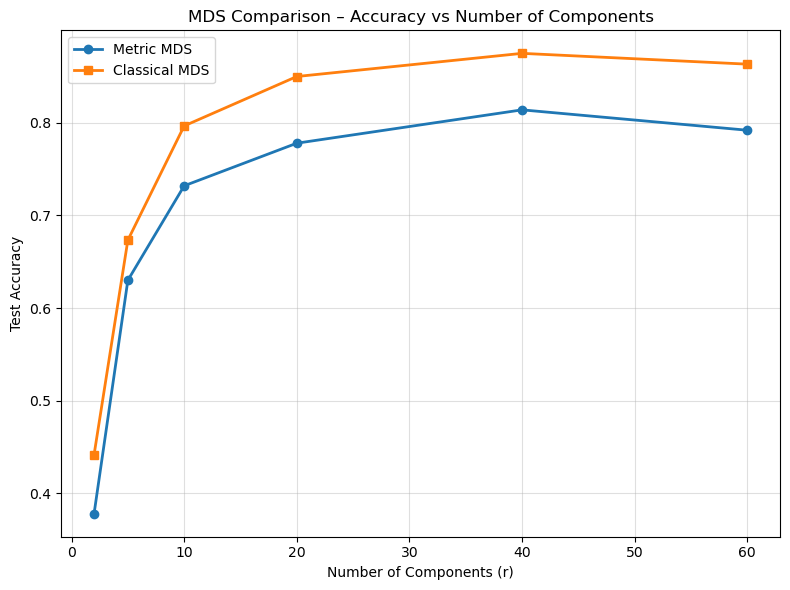

In [15]:
# --- Combined accuracy comparison plot ---
plt.figure(figsize=(8,6))
plt.plot([x[0] for x in results_metric], [x[2] for x in results_metric], marker='o', label="Metric MDS", linewidth=2)
plt.plot(r_vals, acc_vals, marker='s', label="Classical MDS", linewidth=2)
plt.title("MDS Comparison – Accuracy vs Number of Components")
plt.xlabel("Number of Components (r)")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig("docs/mds_accuracy_comparison.png", dpi=150)
plt.show()

Fitting Metric MDS (2D projection)...
Fitting Classical MDS (2D projection)...


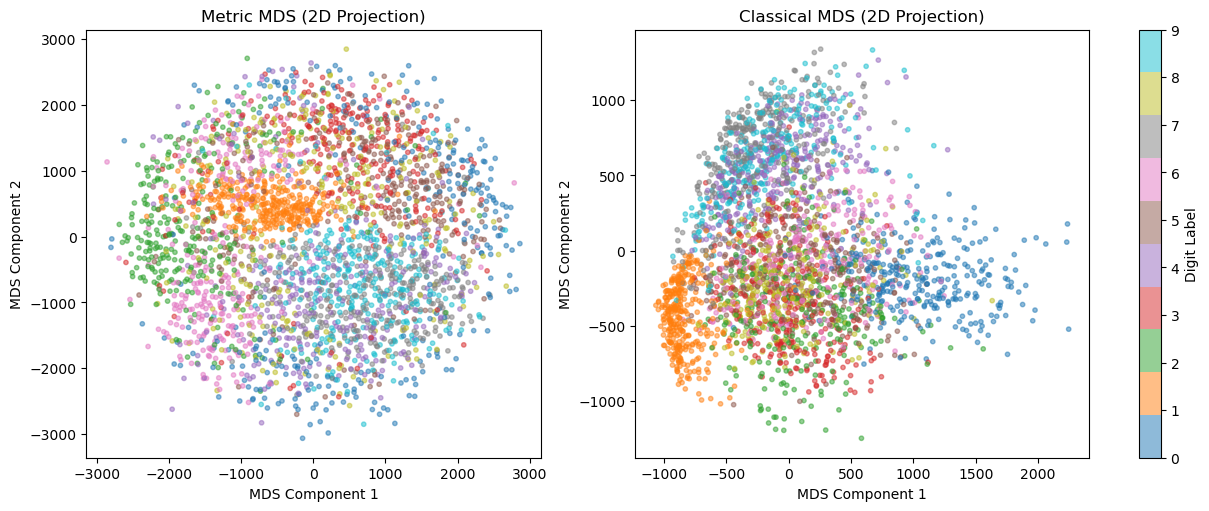

In [16]:
# ==========================
# 2D Visualization: Metric vs Classical MDS
# ==========================

# --- Fit Metric MDS (2D only, use precomputed params ) ---
print("Fitting Metric MDS (2D projection)...")
mds_metric = MDS(
    n_components=2,
    n_init=1,
    max_iter=300,
    random_state=random_state,
    dissimilarity='euclidean',
    normalized_stress='auto',
    metric=True
)
Z_metric = mds_metric.fit_transform(X_scaled)

# --- Classical MDS using custom function ---
print("Fitting Classical MDS (2D projection)...")
D = pairwise_distances(X_scaled)
Z_classical = classical_mds(D, 2)

# --- Plot side-by-side comparison ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
titles = ["Metric MDS (2D Projection)", "Classical MDS (2D Projection)"]
embeddings = [Z_metric, Z_classical]

for ax, Z, title in zip(axes, embeddings, titles):
    sc = ax.scatter(Z[:, 0], Z[:, 1], c=y_sub, cmap="tab10", s=10, alpha=0.5)
    ax.set_xlabel("MDS Component 1")
    ax.set_ylabel("MDS Component 2")
    ax.set_title(title)

fig.colorbar(sc, ax=axes.ravel().tolist(), label="Digit Label")
plt.savefig("docs/mds_metric_vs_classical_2d.png", dpi=150)
plt.show()
